In [1]:
import kagglehub

# Download CIFAR-10
# path = kagglehub.dataset_download("pankrzysiu/cifar10-python") + '/cifar-10-batches-py'
path = '/home/tibless/.cache/kagglehub/datasets/pankrzysiu/cifar10-python/versions/1' + '/cifar-10-batches-py'

print("Path to dataset files:", path)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/pankrzysiu/cifar10-python/versions/1/cifar-10-batches-py


In [2]:
import os
import numpy as np
import jax.numpy as jnp
from jax import random, jit

key = random.PRNGKey(42)

class2name = [
    'airplane',  # 0
    'automobile',  # 1
    'bird',  # 2
    'cat',  # 3
    'deer',  # 4
    'dog',  # 5
    'frog',  # 6
    'horse',  # 7
    'ship',  # 8
    'truck'  # 9
]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(path):
    x_train = []
    y_train = []
    
    for i in range(1, 6):
        file_path = os.path.join(path, f'data_batch_{i}')
        data_dict = unpickle(file_path)
        
        x_train.append(data_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1))
        y_train += data_dict[b'labels']
    
    x_train = np.vstack(x_train)
    y_train = np.array(y_train)

    test_file_path = os.path.join(path, 'test_batch')
    test_dict = unpickle(test_file_path)
    
    x_test = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_dict[b'labels'])

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_cifar10(path)

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000,)


In [3]:
from plugins.minitorch.utils import one_hot

TRAIN = 50000
TEST = 10000
x_train = x_train[:TRAIN].reshape(-1, 32 * 32 * 3) / 255.
y_train = y_train[:TRAIN]
x_test = x_test[:TEST].reshape(-1, 32 * 32 * 3) / 255.
y_test = y_test[:TEST]

x_train = jnp.array(x_train)
y_train = jnp.array(y_train)
x_test = jnp.array(x_test)
y_test = jnp.array(y_test)

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [4]:
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.utils import softmax, cross_entropy_loss
from plugins.minitorch.initer import Initer
from plugins.minitorch.nn import Dense
from plugins.minitorch.loss import CrossEntropyLoss

class mlp_clf:
    def __init__(self, lr=0.01):
        self.config = {
            'fc:0': Dense.get_linear(32 * 32 * 3, 128 * 3),
            'fc:1': Dense.get_linear(128 * 3, 64 * 3),
            'fc:2': Dense.get_linear(64 * 3, 32 * 3),
            'fc:3': Dense.get_linear(32 * 3, 16 * 3),
            'fc:4': Dense.get_linear(16 * 3, 10),
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=512)
        self.losser = CrossEntropyLoss(self.forward)

    def forward(self, x: jnp.ndarray, params, train=False):
        res = x
        key = random.PRNGKey(42)
        for p in params.values():
            # 这里建议使用这种从kv对直接访问的形式，而不是解引用，因为此时的字典顺序由于多线程的不正确同步访问而可能产生了乱序，比如这里：
            # >>>> print(p.keys())
            # >>>> w, b = p.values()
            # 如果你使用这个就会报错，因为之前使用JIT编译之后的函数包含了这个参数，就是说我写了一个函数，这个函数的其中一个参数是param，然后由于JIT的多线程优化，导致被编译之后执行时字典顺序变成：['b', 'w']
            # 因此如果你使用解绑定，那么你就会得到互换的w和b
            # 后面发现即使不使用JIT也会出现相同的问题，因为没有JIT也会有其它多线程的优化，导致这里发生问题。
            res = res @ p['w'] + p['b']  
            res = jnp.maximum(0, res)  # use relu activation function
            res, key = Dense.dropout(res, key, p=0.1, train=train)

        return softmax(res)

    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = self.losser.get_loss(train=True)
        _loss = jit(_loss)
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = self.losser.get_embed_loss(x_test, y_test_proba, train=False)
        _tloss = jit(_tloss)
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for cnt in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params()))

            self.optr.update()
            
            acc.append(_acc(y_train_proba, self.forward(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.forward(x_test, self.optr.get_params())))
            if (cnt + 1) % 10 == 0:
                print(f'>> epoch: {cnt + 1}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss

In [5]:
mlp = mlp_clf(lr=0.001)

epochs = 50
acc, loss, tacc, tloss = mlp.fit(
    x_train=x_train, 
    y_train_proba=y_train_one_hot,
    x_test=x_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs)

[*] oprimizer opened with 97 batches with batch size 512.
>> epoch: 10, train acc: 0.4435599744319916, test acc: 0.4348999857902527
>> epoch: 20, train acc: 0.4587399959564209, test acc: 0.4380999803543091
>> epoch: 30, train acc: 0.47435998916625977, test acc: 0.4486999809741974
>> epoch: 40, train acc: 0.4791799783706665, test acc: 0.4416999816894531
>> epoch: 50, train acc: 0.4632999897003174, test acc: 0.4368000030517578


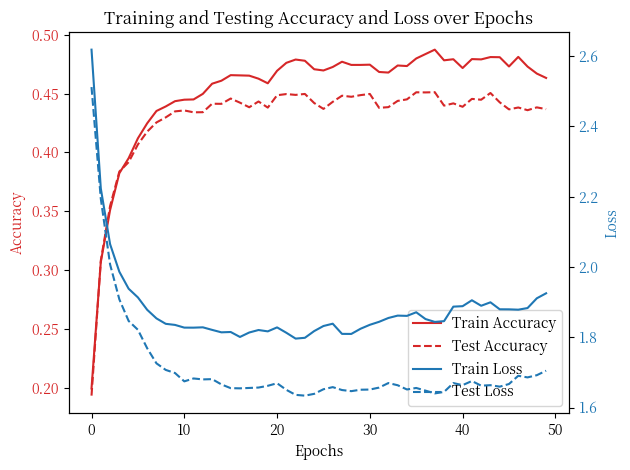

final train, test acc : 0.4632999897003174, 0.4368000030517578
final train, test loss: 1.9250531196594238, 1.7047728300094604


In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
plt.savefig('./assets/mlp_cifar10.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')